In [7]:
#########################################################################
## COMPROBAR GPU ASIGNADA EN COLABORATORY
#########################################################################
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jul 26 06:09:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
#########################################################################
## MONTAR DRIVE
#########################################################################
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
#########################################################################
## LIBRERIAS NECESARIAS
#########################################################################
import tensorflow as tf
import gymnasium as gym
from stable_baselines3 import PPO
from tensorflow.keras.layers import concatenate
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras import layers
import copy
import torch
from sklearn.model_selection import train_test_split

import sys

import os
from stable_baselines3.common.vec_env import DummyVecEnv

In [10]:
############################################################################
## Variables globales
###########################################################################
BATCH_SIZE=32
EPOCHS=100
EPISODES=10
EPISODES_EVALUATE_G=10

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Gym CartPole-v1

Un péndulo está unido mediante una articulación no accionada a un carro que se desplaza a lo largo de una pista sin fricción. El péndulo se coloca verticalmente sobre el carro y el objetivo es equilibrar el poste aplicando fuerzas en dirección izquierda y derecha sobre el carro.

**Espacio de Acciones**: Espacio discreto de tamaño (2)
 * Acción 0: Empujar el carro hacia la izquierda
 * Acción 1: Empujar el carro hacia la derecha

    
   
**Espacio de Observaciones**: Espacio discreto de tamaño (4,)

* La observación es un ndarray con forma (4,) con los valores correspondientes a las siguientes posiciones y velocidades:
         Num    Observación                         Min                            Max

          0    Posición del Carro                 - 4.8                            4.8

          1    Velocidad del Carro                 -Inf                            Inf

          2    Ángulo del Poste              ~ -0.418 rad (-24°)          ~ 0.418 rad (24°)

          3    Velocidad Angular del Poste         -Inf                            Inf

                

In [11]:
# Definimos el entorno
env= gym.make('CartPole-v1')

# Obtenemos el espacio de estados y acciones del entorno
ob_space=env.observation_space

# Mostramos el número de acciones del entorno
print(env.action_space.n)

2




# Discriminador

## Red neuronal del Discriminador

In [12]:
# Red neuronal del Discriminador
# Input: listas de longitud 6, [s,a]
# Output: probabilidad de real o falso [0,1]
discriminator_net=keras.Sequential(
    [
        keras.Input(shape=(None,ob_space.shape[0]+env.action_space.n)),
        layers.Dense(units=20,activation=tf.nn.relu, name='layer1'),
        layers.Dense(units=20,activation=tf.nn.relu, name='layer2'),
        layers.Dense(units=20, activation=tf.nn.relu, name='layer3'),
        layers.Dense(units=1, activation=tf.sigmoid, name='prob'),

    ],
    name="discriminator_net"

)
discriminator_net.summary()

Model: "discriminator_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, None, 20)          140       
                                                                 
 layer2 (Dense)              (None, None, 20)          420       
                                                                 
 layer3 (Dense)              (None, None, 20)          420       
                                                                 
 prob (Dense)                (None, None, 1)           21        
                                                                 
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________


## Función de pérdida del Discriminador

In [13]:
# Función de pérdida del Discriminador
# prob1=>output de la red neuronal anterior cuando recibe como entrada [s,a] de la base de datos, REAL
# prob2=>output de la red neuronal anterior cuando recibe como entrada [s,a] FALSO
def loss_fn_D(prob1, prob2):
    # Esperanza del logaritmo de la D(x)=salida de la red neuronal cuando x=entrada REA
    loss_expert=tf.reduce_mean(tf.math.log(tf.clip_by_value(prob1,0.01,1)))

    # Esperanza del logaritmo de 1-D(x) donde D(x)=salida de la red neuronal cuando x=entrada FALSA
    loss_agent=tf.reduce_mean(tf.math.log(tf.clip_by_value(1-prob2,0.01,1)))
    loss_expert=tf.cast(loss_expert, dtype=tf.float32)
    loss_agent=tf.cast(loss_agent, dtype=tf.float32)
    loss=loss_expert+loss_agent
    loss=-loss


    return loss

## Clase del Discriminador

In [14]:
# Clase DISCRIMINADOR
class Discriminator:
    def __init__(self, env, discriminator_net, expert_s, expert_a, agent_s, agent_a):
        # -Red neuronal del Discriminador
        self.discriminator_net=discriminator_net
        # -Experto: [s,a]
        self.expert_s=expert_s
        self.expert_a=expert_a
        expert_a_one_hot=tf.one_hot(self.expert_a,depth=env.action_space.n)
        # Añadimos ruido para estabilizar el entrenamiento
        expert_a_one_hot+= tf.random.normal(tf.shape(expert_a_one_hot), mean=0.2, stddev=0.1, dtype=tf.float32)/1.2
        self.expert_s_a=tf.concat([self.expert_s,expert_a_one_hot],axis=1)

        # -Agente:  [s,a]
        self.agent_s=agent_s
        self.agent_a=agent_a
        agent_a_one_hot=tf.one_hot(self.agent_a,depth=env.action_space.n)
        agent_a_one_hot+= tf.random.normal(tf.shape(agent_a_one_hot), mean=0.2, stddev=0.1, dtype=tf.float32)/1.2
        self.agent_s_a=tf.concat([self.agent_s,agent_a_one_hot],axis=1)



        # Calculamos la salida de la red para [s,a] del experto y del agente ya que lo necesitamos para reward

        # -Salida de la red neuronal Discriminador para [s,a] expertos(verdaderos)
        self.prob_expert=self.discriminator_net(self.expert_s_a)

        # -Salida  de la red neuronal Discrimiinador para [s,a] Agente(falsos)
        self.prob_agent=self.discriminator_net(self.agent_s_a)

        #-Recompensa obtenida cuando el Agente realiza [s,a] falsas
        self.rewards=tf.math.log(tf.clip_by_value(self.prob_agent,1e-10,1)) #log(P(expert|s,a)) cuando mas grande es mejor el agente


    def getNet(self):
        return self.discriminator_net

    def getAgent_S_A(self):
        return self.agent_s_a

    def getExpert_S_A(self):
        return self.expert_s_a

    def getProb(self):
        return self.prob_expert, self.prob_agent

    def getRewards(self):
        return self.rewards



# Generador

## Redes neuronales del Generador

In [15]:
# Red neuronal del Generador donde se producen acciones
# Input: estados, listas de tamaño 4, s=[s0,s1,s2,s3]
# Output: acciones, listas de tamaño 2, a=[a0,a1]
generator_net_Act=keras.Sequential(
    [
            keras.Input(shape=(None,ob_space.shape[0])),
            layers.Dense(units=20, activation=tf.tanh,name='layer1'),
            layers.Dense(units=20, activation=tf.tanh, name='layer2'),
            layers.Dense(units=2, activation=tf.tanh, name='layer3'),
            layers.Dense(units=2, activation=tf.nn.softmax, name='layer4')

        ],
    name="generator_net_Act"
)

generator_net_Act.summary()

Model: "generator_net_Act"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, None, 20)          100       
                                                                 
 layer2 (Dense)              (None, None, 20)          420       
                                                                 
 layer3 (Dense)              (None, None, 2)           42        
                                                                 
 layer4 (Dense)              (None, None, 2)           6         
                                                                 
Total params: 568
Trainable params: 568
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Red neuronal del Generador donde se producen v_pred
# Input: estados, listas de tamaño 4, s=[s0,s1,s2,s3]
# Output: v_pred, listas de tamaño 1, v_pred

generator_net_v_preds=keras.Sequential(
    [
            keras.Input(shape=(None,ob_space.shape[0])),
            layers.Dense(units=20, activation=tf.tanh,name='layer1'),
            layers.Dense(units=20, activation=tf.tanh, name='layer2'),
            layers.Dense(units=1, activation=None, name='layer3'),
        ],
    name="generator_v_preds"
)

generator_net_v_preds.summary()

Model: "generator_v_preds"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, None, 20)          100       
                                                                 
 layer2 (Dense)              (None, None, 20)          420       
                                                                 
 layer3 (Dense)              (None, None, 1)           21        
                                                                 
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


## Función de pérdida del Generador

In [17]:
# Función de pérdida del Generador
def loss_fn_ppo(act_probs, act_probs_old, gaes, clip_value=0.2):
    #--> Construir el calculo del grafo para loss_clip

    ratios=tf.exp(tf.math.log(tf.clip_by_value(act_probs, 1e-10, 1.0))
                    - tf.math.log(tf.clip_by_value(act_probs_old, 1e-10, 1.0)))

    clipped_ratios= tf.clip_by_value(ratios, clip_value_min=1 - clip_value, clip_value_max=1 + clip_value)
    loss_clip=tf.minimum(tf.multiply(gaes, ratios), tf.multiply(gaes, clipped_ratios))
    loss_clip = tf.reduce_mean(loss_clip)

    # minimizar -loss == maximizar loss
    loss = -loss_clip
    tf.summary.scalar('total', loss)

    return loss

## Clase del Generador

In [18]:
# Clase del GENERADOR: política con su optimizador PPO
# Observesé que cada generador implementa una política distinta, por tanto, se ha decidido llamar a la clase
# Policy_net en lugar de generator
class Policy_net:
    def __init__(self, name: str, env, obs):
        """
        env: gym env
        obs:
        """
        # -Entorno
        self.env=env

        env.reset()

        # -El algoritmo de Optimización de Política Proximal, PPO, combina ideas del algoritmo A2C
        # (que utiliza múltiples trabajadores) y del algoritmo TRPO (que utiliza una región de confianza para
        # mejorar el actor).
        self.model=PPO(policy="MlpPolicy", env=env, verbose=0)


        self.model.learn(total_timesteps=250)

        # -Observación inicial a partir de la cual se crean las acciones iniciales
        # haciendo uso de las redes neuronales del generador
        self.obs=np.reshape(np.array(obs),(1,ob_space.shape[0]))

        # Utilizamos las dos redes neuronales que hemos creado : generator_net_Act y generator_net_v_preds
        # V_pred=>recompensa media de que un agente ejecute una acción

        # -Acción inicial generada con red neuronal y v_pred con red neuronal
        self.act_probs =generator_net_Act(self.obs)
        self.v_preds = generator_net_v_preds(self.obs)

        # -Accion estocástica inicial
        self.act_stochastic = tf.random.categorical(tf.math.log(self.act_probs), num_samples=1)

        # -Acción determinística inicial
        self.act_deterministic = tf.argmax(self.act_probs, axis=1)



    # Para cada estado obs me dice la acción que el agente va a ejecutar sobre el entorno junto con v_pred
    # La elección de la acción puede ser estocástica o determinística
    def act(self, stochastic=True):
        if stochastic:
            return self.act_stochastic, self.v_preds
        else:
            return self.act_deterministic, self.v_preds

    def get_action_prob(self):
        return self.act_probs

    def get_v_preds(self):
        return self.v_preds

    def get_obs(self):
        return self.obs

    def get_model(self):
        return self.model

    def get_trainable_variables(self):
        return self.model.get_parameters()

    # Generar [s,a] falsos
    def generate_fakes(self):

        ob_space = env.observation_space
        reward = 0
        success_num = 0


        # Por cada episodio
        for iteration in range(EPISODES):
            # Inicializo todas las variables
            observations = []
            actions = []
            rewards = []
            run_policy_steps = 0

            truncated=False
            terminated=False


            #La primera acción de cada episodio se crea con la red neuronal

            obs,_=env.reset()

            Old_Policy = Policy_net('old_policy', env, obs=obs)

            act, v_pred = Old_Policy.act(stochastic=True)

            #Convertir de tensor a array
            if type(act)=='Tensor':
                # Crear una sesión de TensorFlow
                sess = tf.compat.v1.Session()

                # Evaluar el tensor dentro de la sesión y obtener el resultado como un objeto NumPy ndarray
                act = sess.run(act)

                # Cerrar la sesión
                sess.close()

            if isinstance(act, tf.Tensor):
                act=act.numpy()

            elif isinstance(act, np.ndarray):
                act=act


            action=int(act)

            next_obs,reward,terminated,truncated, info=env.step(action)

            # --Actualización de variables: ojo no introduzco el estado y accion inicial, solo introduzco los de PPO
            observations.append(next_obs)  # S_0

            Policy = Policy_net('policy',env, obs=[next_obs]) # tenemos una política entrenada

            # Por cada steps en cada episodio, mientras no se llegue a un estado terminal o un estado malo
            while terminated!= True and truncated!= True:
                # --Aumentar el numero de steps
                run_policy_steps += 1

                # --Política para ver la acción asociada al estado
                # Las observaciones son un de la forma [[s_0,s_1,s_2,s_3]] por eso su tamaño es (1,4)
                action, states_oc = Policy.get_model().predict(next_obs)

                action=int(action)

                # --Muevo al Agente al siguiente estado
                next_obs,reward,terminated,truncated,info=env.step(action)

                # --Actualización de variables
                actions.append(action) # A_i-1
                rewards.append(reward) # R_i-1

                # --Si llegamos a un estado final, el juego ha finalizado!!!
                # --Se configura el tablero de nuevo
                if terminated== True:
                    obs = env.reset()
                    reward = -1
                    break
                else:
                    observations.append(next_obs) # O_i
                    self.obs = next_obs

            # Ver si el episodio ha obtendo una recompensa total igual o superior a 195
            if sum(rewards) >= 195:
                success_num += 1
                render = True
                if success_num >= 100:
                    break
            else:
                success_num = 0


        observations = np.reshape(observations, newshape=[-1] + list(ob_space.shape))
        actions = np.array(actions).astype(dtype=np.int32)


        return observations, actions, rewards, Old_Policy, Policy



## PPO Train

In [19]:
# Clase PPOTrain
# Tenemos dos politica theta_i y theta_i+1
# Almacenamos dos políticas Policy_net(cada una de ella con su PPO) y calculamos el valor gaes a partir de valores
# gamma, clip_value, c_1, c_2
# Realizamos aqui el entrenamiento, calculo de gradiente y función de pérdida del PPO para despues usarlo en el generador
# de la GAN
class PPOTrain:

    def __init__(self, Policy, Old_Policy, obs, actions, rewards, gamma=0.95, clip_value=0.2, c_1=1, c_2=0.01):
        """
        arg:
            Policy
            Old_Policy
            gamma
            clip_value
            c_1 parámetro para la diferencia de valores
            c_2 parámetro para el bonus de entropía
        """
        self.Policy = Policy
        self.Old_Policy = Old_Policy
        self.gamma = gamma
        self.obs=obs

        self.pi_trainable = self.Policy.get_trainable_variables()
        self.old_pi_trainable = self.Old_Policy.get_trainable_variables()


        policy_name = "policy"
        old_policy_name="policy"

        policy_dict_ = self.pi_trainable[policy_name]
        old_policy_dict_=self.old_pi_trainable[old_policy_name]

        self.pi=[]
        if policy_name in self.pi_trainable and old_policy_name in self.old_pi_trainable:
            for param_name, param_value in policy_dict_.items():
                # Elimino los pesos que hay en old_policy
                del old_policy_dict_[param_name]
                # Introduzco los pesos de old_policy en policy
                old_policy_dict_[param_name] = param_value
                self.pi.append(param_value)
        else:
            print(f"No se encontró la política con el nombre: {policy_name}")


        # Le asignamos old_pi_trainable=pi_trainable ya que ajustaremos unos nuevos pi_trainable


        self.actions = actions
        self.rewards=rewards
        self.v_preds=self.Old_Policy.get_v_preds()
        self.v_preds_next=self.Policy.get_v_preds()

        #  generative advantage estimator(lambda = 1), ver ppo paper eq(11)
        self.gaes =self.get_gaes(self.rewards, self.v_preds, self.v_preds_next)

        act_probs =self.Policy.get_action_prob()
        act_probs_old =self.Old_Policy.get_action_prob()

        # la probabilidad de las acciones del agente cuando toma la actual política
        act_probs = act_probs * tf.one_hot(indices=self.actions, depth=act_probs.shape[1])
        self.act_probs = tf.reduce_sum(act_probs, axis=1)

        # la probabilidad de las acciones del agente cuando toma la antigua política
        act_probs_old = act_probs_old * tf.one_hot(indices=self.actions, depth=act_probs_old.shape[1])
        self.act_probs_old = tf.reduce_sum(act_probs_old, axis=1)

        self.loss=loss_fn_ppo(self.act_probs, self.act_probs_old, self.gaes)

        self.optimizer =tf.keras.optimizers.Adam(learning_rate=0.001)

    def loss_fn_G(self):
        return loss_fn_ppo(self.act_probs, self.act_probs_old, self.gaes)

    def get_pi_trainable(self):
        return self.pi

    def get_optimizer(self):
        return self.optimizer

    def get_OldPolicy(self):
        return self.Old_Policy

    def get_Policy(self):
        return self.Policy

    def get_gaes(self, rewards, v_preds, v_preds_next):
        deltas = [r_t + self.gamma * v_next - v for r_t, v_next, v in zip(rewards, v_preds_next, v_preds)]
        # calcular la estimación generative advantage (lambda = 1), ver ppo paper eq(11)
        gaes = copy.deepcopy(deltas)
        for t in reversed(range(len(gaes) - 1)):  # # es T-1, donde T es time step con el que se ejecuta la política
            gaes[t] = gaes[t] + self.gamma * gaes[t + 1]
        return gaes

# GAIL

In [20]:
####################################################################################################################
# CLASE GAIL
####################################################################################################################
class GAN(keras.Model):
    # Constructor
    def __init__(self, discriminator, generator):
        super().__init__()
        self.discriminator = discriminator
        self.generator=generator
        self.i=0
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    # Compila el modelo GAN inicializando los optimizadores y la función de pérdida del modelo GAN
    def compile(self,d_optimizer, loss_fn_D ):
        super(GAN, self).compile(run_eagerly=True)
        self.d_optimizer = d_optimizer
        self.loss_fn_D=  loss_fn_D

    # Devuelve las métricas obtenidas con el generador y discriminador
    @property
    def metrics(self):
        return [self.d_loss_metric,self.g_loss_metric]

    # Evaluación del Discriminador
    def evaluate_D(self, X_test):
        len_real = X_test.shape[0]

        generate_observations, generate_actions, rewards, Old_Policy, Policy=self.generator.generate_fakes()

        generate_a_one_hot=np.eye(env.action_space.n)[generate_actions]

        dataset_gen=np.concatenate([generate_observations,generate_a_one_hot],axis=1)


        len_fakes=dataset_gen.shape[0]

        # Compilamos el discriminador como CNN
        self.discriminator.discriminator_net.compile(optimizer=self.d_optimizer, loss=self.loss_fn_D, metrics=['accuracy'])

        # Evaluamos como CNN
        loss_real, acc_real=self.discriminator.discriminator_net.evaluate(X_test, tf.ones((len_real,1)), batch_size=len_real, verbose=1)

        loss_fake, acc_fake=self.discriminator.discriminator_net.evaluate(dataset_gen,tf.ones((len_fakes,1)), batch_size=len_fakes, verbose=1)

        print('>Loss real: ')
        print(loss_real)
        print('>Loss fake: ')
        print(loss_fake)


    # Evaluación del generador
    def evaluate_G(self):
        # Definimos el entorno
        env= gym.make('CartPole-v1')

        # Lista donde amacenaremos la recompensa acumulada de cada episodio.
        # NUESTRO OBJETIVO: Agente aprenda a tomar las acciones que maximicen la recompensa
        rewards=[]

        # Para cada episodio, el Agente se mueve por el Entorno mediante acciones hasta llegar a un estado final
        # siguiendo la política que se ha aprendido en el entrenamiento de la GAN
        for episode in range(EPISODES_EVALUATE_G):
            truncated=False
            terminated=False
            R=0.0
            reward=0.0

            # Estado inicial del juego
            obs,_=env.reset()

            #Interactuamos con el Entorno hasta que lleguemos a un estado final
            while terminated!= True and truncated!=True:
                action, _=self.generator.get_model().predict(obs)
                obs,reward,terminated,truncated, info=env.step(int(action))

                # Incremento la recompensa del episodio i al haber ejecutado el step
                R+=reward

            rewards.append(R)

            # Vemos para el episodio, su recompensa acumulada que es lo que se trata de maximizar
            print("Episode  {} Total reward: {}".format(episode,R))



        # Cierro el entorno
        env.close()



        # Muestro las recompensas obtenidas en cada episodio
        indices = range(0, EPISODES_EVALUATE_G)
        plt.plot(indices,rewards)
        plt.show()

        return np.mean(rewards)

    def train_step(self, X_train):
        # Ojo no tenemos la misma cantidad de datos verdaderos y falsos, por eso calculamos len_real y len_fakes
        # No podemos controlar la creación de x secuencias [s,a] ya que generaremos tantas secuencias como se
        # necesiten para finalizar el juego

        len_real = X_train.shape[0]

        batch_size=len_real

        generate_observations, generate_actions, rewards, Old_Policy, Policy=self.generator.generate_fakes()

        generate_a_one_hot=np.eye(env.action_space.n)[generate_actions]

        if generate_observations.shape[0] == generate_a_one_hot.shape[0]:
          dataset_gen = np.concatenate([generate_observations, generate_a_one_hot], axis=1)
        else:
          generate_a_one_hot_resized = np.resize(generate_a_one_hot, generate_observations.shape)
          dataset_gen = np.concatenate([generate_observations, generate_a_one_hot_resized], axis=1)

        len_fakes=dataset_gen.shape[0]

        # Las etiquetas de las imagenes combinadas las tenemos que crear nosotros introduciendo algo de ruido
        # con tf.random.uniform
        labels = tf.concat(
          [tf.ones((len_real, 1)), tf.zeros((len_fakes, 1))],
          axis=0
        )


        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        if X_train.shape[1] == dataset_gen.shape[1]:
            # Las dimensiones coinciden, se puede realizar la concatenación
          combined_images = tf.concat([X_train, dataset_gen], axis=0)
        else:
          # Aquí debes realizar las modificaciones necesarias para asegurarte de que las dimensiones sean compatibles

          # Por ejemplo, si quieres asegurarte de que ambas dimensiones 1 tengan el mismo tamaño,
          # puedes ajustar el tamaño de dataset_gen para que coincida con el tamaño de X_train
          dataset_gen_resized = dataset_gen[:, :X_train.shape[1]]  # Ajustar el tamaño al tamaño de X_train

          # Luego, realizar la concatenación
          combined_images = tf.concat([X_train, dataset_gen_resized], axis=0)

        #############  PASO 1:  ENTRENAMIENTO DEL DISCRIMINADOR ##############################################

        # Entrenamiento del discriminador con las [s,a] del agente y del experto combinadas, esto es,
        # le pasamos un conjunto que tiene tanto imágenes reales como imágenes falsas
        with tf.GradientTape() as tape:
            predictions=np.zeros((len_real+len_fakes,6))
            # Predicciones obtenidas con el discriminador
            predictions = self.discriminator.discriminator_net(combined_images)
            # Valor de la función de pérdida al comparar las predicciones con las etiquetas reales
            d_loss = self.loss_fn_D(labels, predictions)

        # Calculo del gradiente y actualización del gradiente
        grads = tape.gradient(d_loss, self.discriminator.getNet().trainable_weights)

        self.d_optimizer.apply_gradients(
          zip(grads, self.discriminator.getNet().trainable_weights)
        )


        d_rewards = discriminator.getRewards()


        ############# PASO 2: ENTRENAMIENTO DEL GENERADOR=POLÍTICA  ##############################

        ppotrain=PPOTrain(Policy,Old_Policy,actions=generate_actions,rewards=rewards, obs=generate_observations[0])


        with tf.GradientTape() as tape:
            g_loss = ppotrain.loss_fn_G()


        g_loss = tf.cast(g_loss, dtype=tf.float32)


        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        # Por cada 10 epoca quiero conocer los datos de recompensa
        if (self.i+1)%10==0:
          rewardMean=self.evaluate_G()
          print('\nEpoca:', self.i)
          print('\nRecompensa de Media:', rewardMean, '\n')

        self.i=self.i+1
        return {"d_loss": self.d_loss_metric.result(),
                    "g_loss": self.g_loss_metric.result()}


# Lectura de la Base de Datos

In [21]:
###################################################################################################################################################################
# CREACIÓN DE ARCHIVOS CSV DE ACTIONS.CSV Y OBSERVATIONS.CSV
#################################################################################################################################################################
# Obtenemos observaciones y acciones expertas:
'''
import csv

expert_observations=[]
expert_actions=[]


env = gym.make('CartPole-v1')

# Definimos el modelo experto
model = PPO("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=25000)



expert_observations = '/content/drive/MyDrive/Colab Notebooks/Trayectorias expertas news/observations_CartPole.csv'
expert_actions = '/content/drive/MyDrive/Colab Notebooks/Trayectorias expertas news/actions_CartPole.csv'
with open(expert_observations, 'w', newline='') as expert_observations_csv:
    # Crear el escritor CSV
    escritor_csv_obs=csv.writer(expert_observations_csv)
    with open(expert_actions, 'w', newline='') as expert_actions_csv:
        escritor_csv_act=csv.writer(expert_actions_csv)
        for i in range(9):
            obs, info = env.reset()
            terminated = False
            truncated=False
            while not terminated and not truncated:
                a , _ = model.predict(obs)
                obs, reward, terminated, truncated, info = env.step(a)

                escritor_csv_obs.writerow(obs)

                escritor_csv_act.writerow([a])

env.close()'''

'\nimport csv\n\nexpert_observations=[]\nexpert_actions=[]\n\n\nenv = gym.make(\'CartPole-v1\')\n\n# Definimos el modelo experto\nmodel = PPO("MlpPolicy", env, verbose=0)\nmodel.learn(total_timesteps=25000)\n\n\n\nexpert_observations = \'/content/drive/MyDrive/Colab Notebooks/Trayectorias expertas news/observations_CartPole.csv\'\nexpert_actions = \'/content/drive/MyDrive/Colab Notebooks/Trayectorias expertas news/actions_CartPole.csv\'\nwith open(expert_observations, \'w\', newline=\'\') as expert_observations_csv:\n    # Crear el escritor CSV\n    escritor_csv_obs=csv.writer(expert_observations_csv)\n    with open(expert_actions, \'w\', newline=\'\') as expert_actions_csv:\n        escritor_csv_act=csv.writer(expert_actions_csv)\n        for i in range(9):\n            obs, info = env.reset()\n            terminated = False\n            truncated=False\n            while not terminated and not truncated:\n                a , _ = model.predict(obs)\n                obs, reward, termin

In [22]:
expert_observations = np.genfromtxt("/content/drive/MyDrive/Colab Notebooks/Trayectorias expertas news/observations_CartPole.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('/content/drive/MyDrive/Colab Notebooks/Trayectorias expertas news/actions_CartPole.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[-0.01998276  0.1706307  -0.00239723 -0.31093898]
 [-0.01657015 -0.02445703 -0.00861601 -0.01901303]
 [-0.01705929  0.17078742 -0.00899627 -0.3144019 ]
 ...
 [ 0.6510444   0.69293946 -0.00473277 -0.10203333]
 [ 0.6649032   0.49788564 -0.00677344  0.18915267]
 [ 0.67486095  0.69310385 -0.00299038 -0.10565928]]
	Acciones reales: 
 [1 0 1 ... 0 0 1]


In [23]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[-0.01998276  0.1706307  -0.00239723 -0.31093898  0.          1.        ]
 [-0.01657015 -0.02445703 -0.00861601 -0.01901303  1.          0.        ]
 [-0.01705929  0.17078742 -0.00899627 -0.3144019   0.          1.        ]
 ...
 [ 0.6510444   0.69293946 -0.00473277 -0.10203333  1.          0.        ]
 [ 0.6649032   0.49788564 -0.00677344  0.18915267  1.          0.        ]
 [ 0.67486095  0.69310385 -0.00299038 -0.10565928  0.          1.        ]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 3379
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 845


# Definición de generador, dicriminador y generamos [s,a]^*


In [24]:
env= gym.make('CartPole-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)


# EXPERIMENTACIÓN DE GAIL CON CARTPOLE

## Definición de GAIL

In [25]:
gan=GAN(discriminator=discriminator,generator=generator)

## Compilación de GAIL

In [26]:
tf.config.run_functions_eagerly(True)
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss_fn_D=loss_fn_D
)

## Entrenamiento de GAIL

En la ejecución de la primera época se puede ver como g_loss empieza a disminuir mientras d_loss empieza a aumentar,
un comportamiento normal en las GANs ya que el generador produce muestras con intención de engañar al discriminador y lo consigue.

Cuando el Discriminador aprenda los patrones con los que el generador esta generando las secuencias falsas, entonces
el discriminador habra aprendido y su pérdida disminuirá mientras que g_loss incrementa

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 86s 86s/step - d_loss: 0.7966 - g_loss: nan
Epoch 2/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.8196 - g_loss: -1.2702
Epoch 3/100
1/1 [==============================] - 85s 85s/step - d_loss: 0.8612 - g_loss: -0.6837
Epoch 4/100
1/1 [==============================] - 85s 85s/step - d_loss: 0.8067 - g_loss: -0.7285
Epoch 5/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.8473 - g_loss: -0.9493
Epoch 6/100
1/1 [==============================] - 85s 85s/step - d_loss: 0.8058 - g_loss: -1.4134
Epoch 7/100
1/1 [==============================] - 87s 87s/step - d_loss: 0.8244 - g_loss: -0.5583
Epoch 8/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.8124 - g_loss: -0.4041
Epoch 9/100
1/1 [==============================] - 85s 85s/step - d_loss: 0.7925 - g_loss: -1.1476
Epoch 10/100
Episode  0 Total reward: 21.0
Episode  1 Total reward: 30.0
Episode  2 Total reward: 15.0
Episode  3 Total rewar

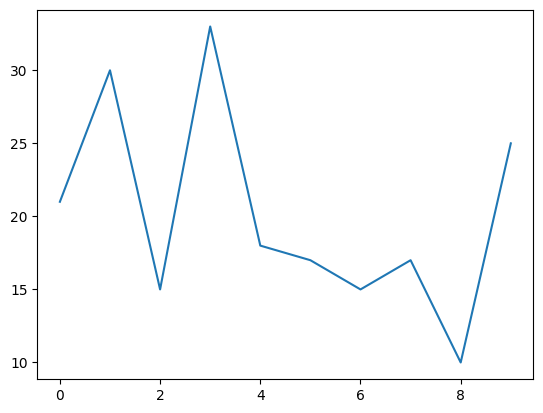


Epoca: 9

Recompensa de Media: 20.1 

1/1 [==============================] - 86s 86s/step - d_loss: 0.7895 - g_loss: -0.9318
Epoch 11/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.8026 - g_loss: -1.5329
Epoch 12/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7921 - g_loss: -1.1276
Epoch 13/100
1/1 [==============================] - 85s 85s/step - d_loss: 0.7960 - g_loss: -0.8405
Epoch 14/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7966 - g_loss: -0.9138
Epoch 15/100
1/1 [==============================] - 87s 87s/step - d_loss: 0.8205 - g_loss: -0.5797
Epoch 16/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7894 - g_loss: -1.5825
Epoch 17/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7791 - g_loss: -1.2907
Epoch 18/100
1/1 [==============================] - 87s 87s/step - d_loss: 0.7768 - g_loss: -0.9487
Epoch 19/100
1/1 [==============================] - 86s 86s/step - d_loss:

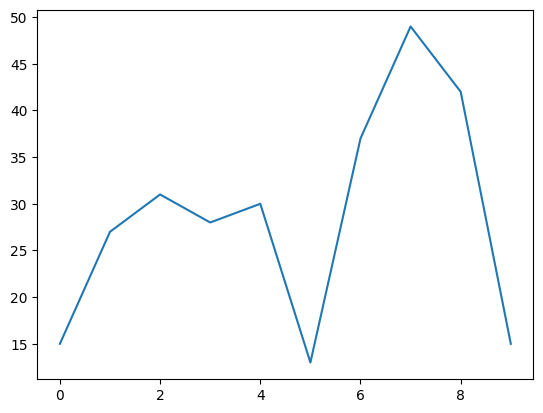


Epoca: 19

Recompensa de Media: 28.7 

1/1 [==============================] - 87s 87s/step - d_loss: 0.7905 - g_loss: -0.9836
Epoch 21/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7769 - g_loss: -1.2130
Epoch 22/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7774 - g_loss: -1.5030
Epoch 23/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7764 - g_loss: -1.4744
Epoch 24/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.8051 - g_loss: -1.0193
Epoch 25/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.8247 - g_loss: -0.9899
Epoch 26/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7753 - g_loss: -1.5300
Epoch 27/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7708 - g_loss: -0.8555
Epoch 28/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7721 - g_loss: -1.3682
Epoch 29/100
1/1 [==============================] - 85s 85s/step - d_loss

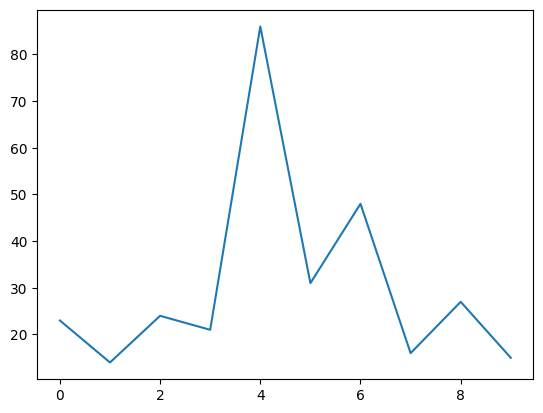


Epoca: 29

Recompensa de Media: 30.5 

1/1 [==============================] - 86s 86s/step - d_loss: 0.7783 - g_loss: -0.9918
Epoch 31/100
1/1 [==============================] - 87s 87s/step - d_loss: 0.7626 - g_loss: -1.1851
Epoch 32/100
1/1 [==============================] - 87s 87s/step - d_loss: 0.7727 - g_loss: -0.5931
Epoch 33/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.8083 - g_loss: -0.3217
Epoch 34/100
1/1 [==============================] - 87s 87s/step - d_loss: 0.7914 - g_loss: -0.8632
Epoch 35/100
1/1 [==============================] - 87s 87s/step - d_loss: 0.7793 - g_loss: -1.1945
Epoch 36/100
1/1 [==============================] - 85s 85s/step - d_loss: 0.7606 - g_loss: -1.1806
Epoch 37/100
1/1 [==============================] - 87s 87s/step - d_loss: 0.8088 - g_loss: -0.7197
Epoch 38/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7604 - g_loss: -1.0115
Epoch 39/100
1/1 [==============================] - 86s 86s/step - d_loss

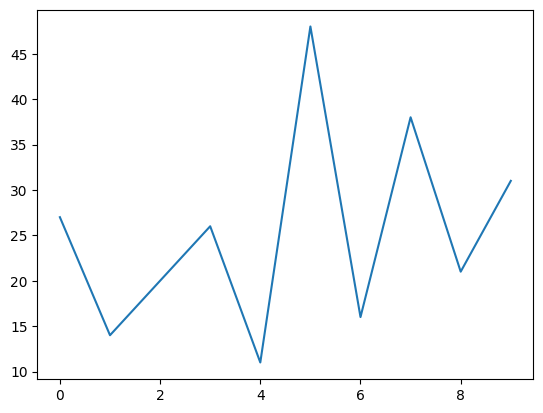


Epoca: 39

Recompensa de Media: 25.2 

1/1 [==============================] - 87s 87s/step - d_loss: 0.8247 - g_loss: -0.5667
Epoch 41/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7539 - g_loss: -1.6373
Epoch 42/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7699 - g_loss: -1.5075
Epoch 43/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7656 - g_loss: -0.4351
Epoch 44/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7655 - g_loss: -1.1344
Epoch 45/100
1/1 [==============================] - 87s 87s/step - d_loss: 0.7496 - g_loss: -0.7124
Epoch 46/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.8018 - g_loss: -0.5798
Epoch 47/100
1/1 [==============================] - 87s 87s/step - d_loss: 0.8010 - g_loss: -1.0145
Epoch 48/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7691 - g_loss: -0.3273
Epoch 49/100
1/1 [==============================] - 87s 87s/step - d_loss

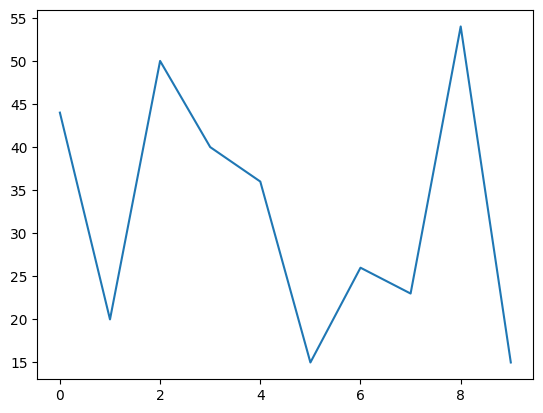


Epoca: 49

Recompensa de Media: 32.3 

1/1 [==============================] - 87s 87s/step - d_loss: 0.7860 - g_loss: -0.8441
Epoch 51/100
1/1 [==============================] - 87s 87s/step - d_loss: 0.7458 - g_loss: -0.7308
Epoch 52/100
1/1 [==============================] - 87s 87s/step - d_loss: 0.7599 - g_loss: -0.3689
Epoch 53/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7531 - g_loss: -0.4882
Epoch 54/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7609 - g_loss: -1.2685
Epoch 55/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7507 - g_loss: -0.8372
Epoch 56/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7376 - g_loss: -1.4674
Epoch 57/100
1/1 [==============================] - 85s 85s/step - d_loss: 0.7519 - g_loss: -0.9851
Epoch 58/100
1/1 [==============================] - 85s 85s/step - d_loss: 0.7463 - g_loss: -0.9349
Epoch 59/100
1/1 [==============================] - 86s 86s/step - d_loss

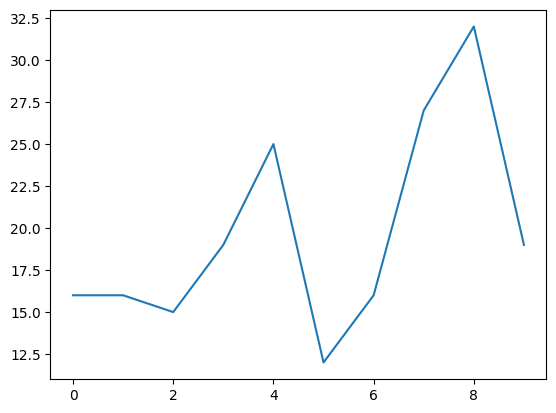


Epoca: 59

Recompensa de Media: 19.7 

1/1 [==============================] - 86s 86s/step - d_loss: 0.7341 - g_loss: nan
Epoch 61/100
1/1 [==============================] - 85s 85s/step - d_loss: 0.8008 - g_loss: -1.0046
Epoch 62/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7583 - g_loss: -1.1349
Epoch 63/100
1/1 [==============================] - 87s 87s/step - d_loss: 0.7855 - g_loss: -1.0512
Epoch 64/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7397 - g_loss: -1.4207
Epoch 65/100
1/1 [==============================] - 87s 87s/step - d_loss: 0.7368 - g_loss: -1.1716
Epoch 66/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7434 - g_loss: -1.4498
Epoch 67/100
1/1 [==============================] - 87s 87s/step - d_loss: 0.7447 - g_loss: -0.9689
Epoch 68/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7322 - g_loss: -0.6092
Epoch 69/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.

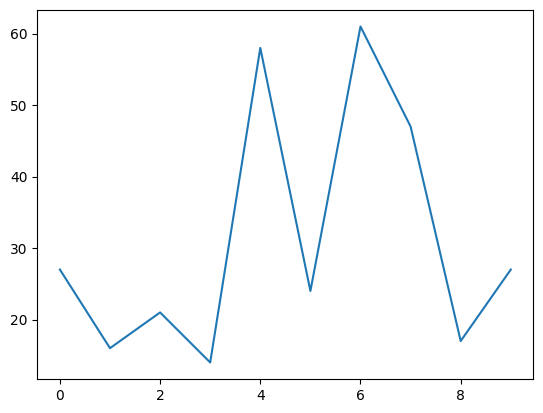


Epoca: 69

Recompensa de Media: 31.2 

1/1 [==============================] - 88s 88s/step - d_loss: 0.7492 - g_loss: -1.3616
Epoch 71/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7350 - g_loss: -1.5033
Epoch 72/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7878 - g_loss: -0.5084
Epoch 73/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7268 - g_loss: -1.3140
Epoch 74/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7446 - g_loss: -1.3169
Epoch 75/100
1/1 [==============================] - 85s 85s/step - d_loss: 0.7916 - g_loss: -1.5285
Epoch 76/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7369 - g_loss: -0.5496
Epoch 77/100
1/1 [==============================] - 85s 85s/step - d_loss: 0.7213 - g_loss: -1.5198
Epoch 78/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7468 - g_loss: -1.5036
Epoch 79/100
1/1 [==============================] - 87s 87s/step - d_loss

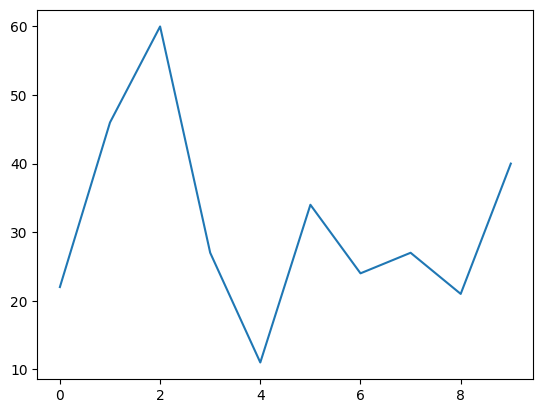


Epoca: 79

Recompensa de Media: 31.2 

1/1 [==============================] - 87s 87s/step - d_loss: 0.7515 - g_loss: -1.0207
Epoch 81/100
1/1 [==============================] - 85s 85s/step - d_loss: 0.7390 - g_loss: -1.4343
Epoch 82/100
1/1 [==============================] - 84s 84s/step - d_loss: 0.7184 - g_loss: -1.5254
Epoch 83/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7729 - g_loss: -1.2477
Epoch 84/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7861 - g_loss: -0.4704
Epoch 85/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7143 - g_loss: -1.5347
Epoch 86/100
1/1 [==============================] - 87s 87s/step - d_loss: 0.7096 - g_loss: nan
Epoch 87/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7541 - g_loss: -0.8639
Epoch 88/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7303 - g_loss: -0.3598
Epoch 89/100
1/1 [==============================] - 85s 85s/step - d_loss: 0.

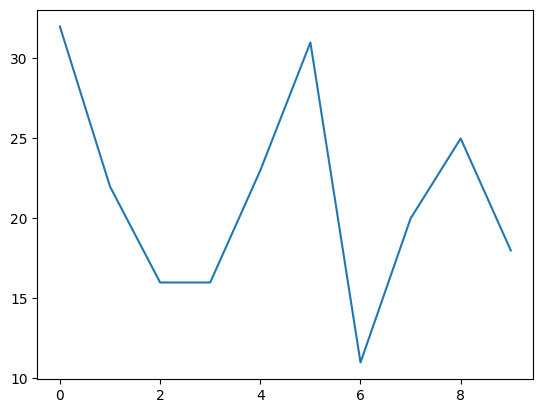


Epoca: 89

Recompensa de Media: 21.4 

1/1 [==============================] - 86s 86s/step - d_loss: 0.7058 - g_loss: nan
Epoch 91/100
1/1 [==============================] - 87s 87s/step - d_loss: 0.7228 - g_loss: -0.9918
Epoch 92/100
1/1 [==============================] - 85s 85s/step - d_loss: 0.7117 - g_loss: -1.3103
Epoch 93/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7053 - g_loss: -1.4876
Epoch 94/100
1/1 [==============================] - 87s 87s/step - d_loss: 0.7035 - g_loss: -1.5749
Epoch 95/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7191 - g_loss: -1.3017
Epoch 96/100
1/1 [==============================] - 85s 85s/step - d_loss: 0.7521 - g_loss: -1.3107
Epoch 97/100
1/1 [==============================] - 86s 86s/step - d_loss: 0.7277 - g_loss: -1.5351
Epoch 98/100
1/1 [==============================] - 87s 87s/step - d_loss: 0.7075 - g_loss: -0.6684
Epoch 99/100
1/1 [==============================] - 85s 85s/step - d_loss: 0.

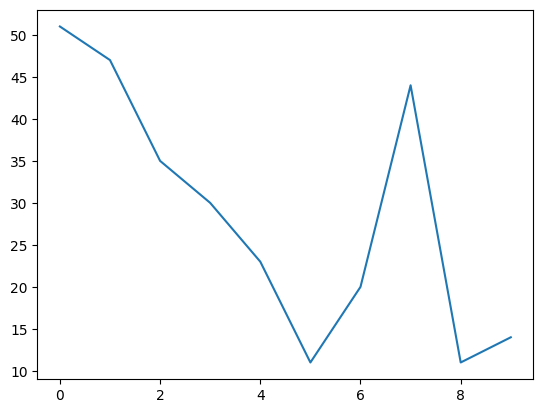


Epoca: 99

Recompensa de Media: 28.6 

1/1 [==============================] - 86s 86s/step - d_loss: 0.6966 - g_loss: nan


In [27]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)


history=gan.fit(X_train,
    epochs=EPOCHS, batch_size=3379)

## Evaluación del Discriminador

In [28]:
# Evaluamos el Discriminador de GAIL en el TEST
gan.evaluate_D(X_test)

1/1 [==============================] - 0s 31ms/step - loss: 0.7501 - accuracy: 0.5000
>Loss real: 
0.6953935623168945
>Loss fake: 
0.7501243352890015


## Evaluación del Generador

Episode  0 Total reward: 27.0
Episode  1 Total reward: 20.0
Episode  2 Total reward: 12.0
Episode  3 Total reward: 16.0
Episode  4 Total reward: 25.0
Episode  5 Total reward: 19.0
Episode  6 Total reward: 17.0
Episode  7 Total reward: 12.0
Episode  8 Total reward: 18.0
Episode  9 Total reward: 25.0


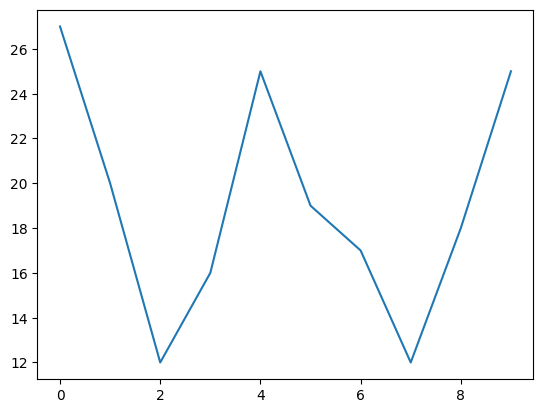

19.1

In [29]:
gan.evaluate_G()